<ipython-input-19-2cadd9f95e29>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/wtmr-model/WTMRNet2_HMDB51.pth", map_location=device)


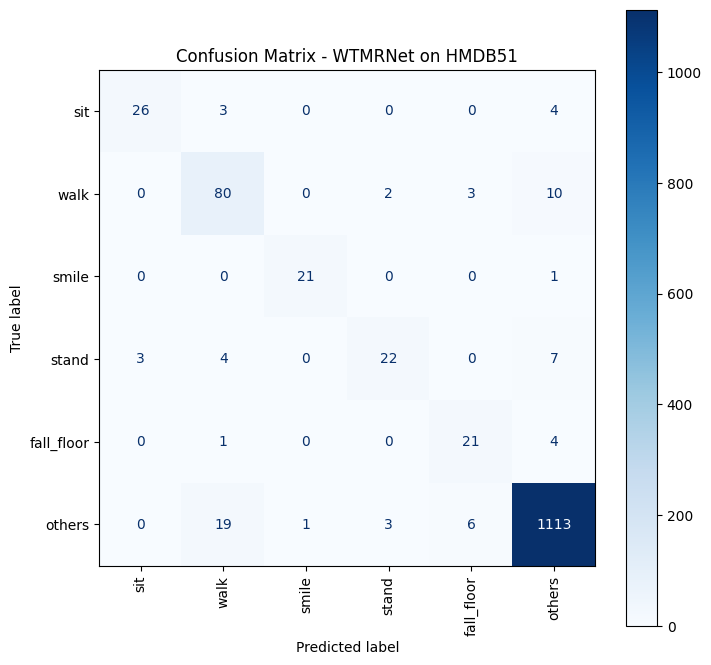

In [19]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(categories)

model = WTMRNet(num_classes=num_classes).to(device)
model = torch.load("/kaggle/input/wtmr-model/WTMRNet2_HMDB51.pth", map_location=device)
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.amp.autocast("cuda"):
            outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())


main_categories = ['sit', 'walk', 'smile', 'stand', 'fall_floor']
reduced_categories = main_categories + ['others']

category_map = {cat: (cat if cat in main_categories else 'others') for cat in categories}

true_label_names = [categories[i] for i in true_labels]
pred_label_names = [categories[i] for i in pred_labels]

true_reduced_names = [category_map[name] for name in true_label_names]
pred_reduced_names = [category_map[name] for name in pred_label_names]

label_to_index = {label: i for i, label in enumerate(reduced_categories)}
true_encoded = [label_to_index[name] for name in true_reduced_names]
pred_encoded = [label_to_index[name] for name in pred_reduced_names]

cm = confusion_matrix(true_encoded, pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reduced_categories)

fig, ax = plt.subplots(figsize=(8, 8))  
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix - WTMRNet on HMDB51")
plt.show()


In [2]:
!pip install --quiet ptflops thop

In [6]:
import torch
from ptflops import get_model_complexity_info
from thop import profile
import time
import numpy as np

class MultiRegionCNN(nn.Module):
    def __init__(self):
        super(MultiRegionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(B, T, -1, x.size(2), x.size(3))
        return x

from einops import rearrange
from timm.models.vision_transformer import Block

class TimeSformer(nn.Module):
    def __init__(self, num_frames=16, img_size=56, patch_size=8, embed_dim=768, num_heads=12, depth=12, num_classes=51):
        super(TimeSformer, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * 128
        self.embed_dim = embed_dim
        self.num_frames = num_frames

        self.patch_embedding = nn.Linear(self.patch_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))
        self.temporal_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = rearrange(x, 'b t c (h p1) (w p2) -> (b t) (h w) (p1 p2 c)', p1=8, p2=8)
        x = x.view(B * T, self.num_patches, self.patch_dim)
        x = self.patch_embedding(x)
        x = x + self.position_embedding[:, :x.shape[1], :]
        x = rearrange(x, '(b t) n d -> b (t n) d', b=B)
        x = x + self.temporal_embedding[:, :x.shape[1], :]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x[:, 0])
        return self.head(x)

class WTMRNet(nn.Module):
    def __init__(self, num_classes=51):
        super(WTMRNet, self).__init__()
        self.multi_region_cnn = MultiRegionCNN()
        self.timesformer = TimeSformer(num_classes=num_classes)

    def forward(self, x):
        x = self.multi_region_cnn(x)
        x = self.timesformer(x)
        return x

model = WTMRNet(num_classes=51)
model = torch.load("/kaggle/input/wtmr-model/WTMRNet2_HMDB51.pth", map_location="cpu")
model.eval()

# Compute GFLOPs and Parameters
dummy_input = torch.randn(1, 16, 1, 224, 224)  
macs, params = profile(model, inputs=(dummy_input, ), verbose=False)
print(f"Model Parameters (Total): {params / 1e6:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {macs / 1e9:.2f} GFLOPs")

# Compute Throughput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = dummy_input.to(device)

with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

    repetitions = 100
    times = []
    for _ in range(repetitions):
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    throughput = 1.0 / avg_time

print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")

avg_epoch_time_sec = 390 
num_epochs = 50
total_training_time_sec = avg_epoch_time_sec * num_epochs
hours = total_training_time_sec / 3600

print(f"Total Training Time: {hours:.2f} hours")

<ipython-input-6-c58f614c5c71>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/wtmr-model/WTMRNet2_HMDB51.pth", map_location="cpu")


Model Parameters (Total): 91.43 M
GFLOPs (Multiply-Accumulate Ops): 86.92 GFLOPs
Average Inference Time per Clip: 0.0776 seconds
Throughput: 12.88 clips/second
Total Training Time: 5.42 hours


In [6]:
import torch
from ptflops import get_model_complexity_info
from thop import profile
import time
import numpy as np
import torch.nn as nn

class MultiRegionCNN2(nn.Module):
    def __init__(self):
        super(MultiRegionCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(128 * 56 * 56, 51)  

    def forward(self, x):
        B, T, C, H, W = x.shape  
        
        x = x.view(B * T, C, H, W)
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(B, T, -1)  
        x = x.mean(dim=1) 
        
        x = self.fc(x)  
        return x
        
model = MultiRegionCNN2()

checkpoint = torch.load("/kaggle/working/WMRC_Net_HMDB51.pth", map_location="cpu")

model.load_state_dict(checkpoint["model_state_dict"])

model.eval()


# Compute GFLOPs and Parameters
dummy_input = torch.randn(1, 16, 1, 224, 224)  
macs, params = profile(model, inputs=(dummy_input, ), verbose=False)
print(f"Model Parameters (Total): {params / 1e6:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {macs / 1e9:.2f} GFLOPs")

# Compute Throughput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = dummy_input.to(device)

with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

    repetitions = 100
    times = []
    for _ in range(repetitions):
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    throughput = 1.0 / avg_time

print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")

avg_epoch_time_sec = 241
num_epochs = 50
total_training_time_sec = avg_epoch_time_sec * num_epochs
hours = total_training_time_sec / 3600

print(f"Total Training Time: {hours:.2f} hours")

<ipython-input-6-a7f3ab08acf1>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/WMRC_Net_HMDB51.pth", map_location="cpu")


Model Parameters (Total): 20.55 M
GFLOPs (Multiply-Accumulate Ops): 15.28 GFLOPs
Average Inference Time per Clip: 0.0064 seconds
Throughput: 157.36 clips/second
Total Training Time: 3.35 hours


In [8]:
import torch
from ptflops import get_model_complexity_info
from thop import profile
import time
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast  
from torch.optim.lr_scheduler import ReduceLROnPlateau
from einops import rearrange
from timm.models.vision_transformer import Block

class TimeSformer2(nn.Module):
    def __init__(self, num_classes=51, img_size=224, patch_size=16, num_frames=8, embed_dim=768, num_layers=6):
        super().__init__()
        self.num_patches_per_frame = (img_size // patch_size) ** 2  
        self.total_patches = self.num_patches_per_frame * 16   

        self.patch_embedding = nn.Linear(patch_size * patch_size * 1, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, self.total_patches, embed_dim)) 

        self.blocks = nn.ModuleList([Block(embed_dim, 12) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.shape
        if t != 16:
            raise ValueError(f"Expected 16 frames, but got {t}") 
 

        x = rearrange(x, 'b t c (h p1) (w p2) -> b (t h w) (p1 p2 c)', p1=16, p2=16)
        x = self.patch_embedding(x)  
        x = x + self.position_embedding  

        for block in self.blocks:
            x = block(x)

        x = self.norm(x.mean(dim=1))  
        return self.head(x)
        
model = TimeSformer2()

checkpoint = torch.load("/kaggle/working/TimeSformer_HMDB51.pth", map_location="cpu")

model.load_state_dict(checkpoint["model_state_dict"])

model.eval()


# Compute GFLOPs and Parameters
dummy_input = torch.randn(1, 16, 1, 224, 224)  
macs, params = profile(model, inputs=(dummy_input, ), verbose=False)
print(f"Model Parameters (Total): {params / 1e6:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {macs / 1e9:.2f} GFLOPs")

# Compute Throughput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = dummy_input.to(device)

with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

    repetitions = 100
    times = []
    for _ in range(repetitions):
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    throughput = 1.0 / avg_time

print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")

avg_epoch_time_sec = 699
num_epochs = 10
total_training_time_sec = avg_epoch_time_sec * num_epochs
hours = total_training_time_sec / 3600

print(f"Total Training Time: {hours:.2f} hours")

<ipython-input-8-662c0962e1ab>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/TimeSformer_HMDB51.pth", map_location="cpu")


Model Parameters (Total): 42.75 M
GFLOPs (Multiply-Accumulate Ops): 133.91 GFLOPs
Average Inference Time per Clip: 0.1625 seconds
Throughput: 6.16 clips/second
Total Training Time: 1.94 hours
